In [68]:
from neo4j import GraphDatabase
from pyvis.network import Network
import networkx as nx
import matplotlib.pyplot as plt

class Neo4jVisualizer:
    def __init__(self, uri, user, password):
        """初始化Neo4j连接"""
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
        
    def close(self):
        """关闭数据库连接"""
        self.driver.close()

    def get_node_info(self,record,inx,nodes,node_ids):
        """获取节点信息"""
        if record[inx].element_id not in node_ids:
                    properties=dict(record[inx])
                    # print(list(record[inx].labels))
                    nodes.append({
                        "id": record[inx].element_id,
                        "labels": list(record[inx].labels),
                        "name":properties['name'],
                        "properties": properties
                    })
                    node_ids.add(record[inx].element_id)

    def get_subgraph(self, node_id=None, depth=1, limit=50):
        """
        获取子图数据
        :param node_id: 起始节点ID，None则随机获取
        :param depth: 遍历深度
        :param limit: 最大节点数量限制
        :return: 节点和关系的列表
        """

        
        if node_id:
            # 从指定节点开始获取子图
            query = f"""
            MATCH (n)-[r*1..{depth}]-(m)
            WHERE n.id = $node_id
            RETURN n, r, m
            LIMIT $limit
            """
            parameters = {"node_id": node_id, "limit": limit}
        else:
            # 随机获取部分图数据
            query = """
            MATCH (n)-[r]->(m)
            RETURN n, r, m
            LIMIT $limit
            """
            parameters = {"limit": limit}
            
        with self.driver.session() as session:
            result = session.run(query, parameters)
            
            nodes = []
            relationships = []
            
            # 收集节点和关系
            node_ids = set()
            for record in result:
                # print(record)
                # 处理起始节点
                self.get_node_info(record,'n',nodes,node_ids)
                    
                # 处理目标节点
                self.get_node_info(record,'m',nodes,node_ids)
                    
                # 处理关系
                if isinstance(record["r"], list):
                    # 处理路径中的多个关系
                    for rel in record["r"]:
                        relationships.append({
                            "source": rel.start_node.element_id,
                            "target": rel.end_node.element_id,
                            "type": rel.type,
                            "properties": dict(rel)
                        })
                else:
                    relationships.append({
                        "source": record["r"].start_node.element_id,
                        "target": record["r"].end_node.element_id,
                        "type": record["r"].type,
                        "properties": dict(record["r"])
                    })
                    
            return nodes, relationships
            
    def visualize_with_pyvis(self, nodes, relationships, output_file="neo4j_graph.html"):
        """使用PyVis创建交互式可视化"""
        # 创建网络
        net = Network(
            height="800px", 
            width="100%", 
            bgcolor="#222222", 
            font_color="white",
            directed=True,
            notebook=True
        )
        
        # 为不同标签的节点分配不同颜色
        label_colors = {
                "人物": "#FFB6C1",        
                "国家": "#1E90FF",       
                "时间": "#FFD700",       
                "理论": "#8A2BE2",       
                "TextChunk": "#D3D3D3",  
                "Entity": "#90EE90",     
                "概念": "#FF8C00",       
                "技术": "#20B2AA",       
                 "default":  "#ffffff"       
        }
        
        # 添加节点
        for node in nodes:
            # 确定节点颜色
            node_color = label_colors["default"]
            for label in node["labels"]:
                # print(label)
                if label in label_colors:
                    node_color = label_colors[label]
                    break
                    
            # 节点标题（悬停时显示）
            title = f"Name: {node['name']}<br>"
            title += f"Labels: {', '.join(node['labels'])}<br>"
            for key, value in node["properties"].items():
                title += f"{key}: {value}<br>"
                
            net.add_node(
                node["id"],
                label=str(node["name"]), #node["labels"][0] if node["labels"] else str(node["name"]),
                color=node_color,
                title=title,
                font={"size": 14,"color": "#2D18F1"}
            )
        
        # 添加关系
        for rel in relationships:
            title = f"{rel['type']}<br>"
            for key, value in rel["properties"].items():
                title += f"{key}: {value}<br>"
                
            net.add_edge(
                rel["source"], 
                rel["target"], 
                label=rel["type"],
                title=title,
                color="#cccccc",
                font={"size": 10}
            )
        
        # 保存为HTML文件
        net.show(output_file)
        print(f"可视化已保存到 {output_file}")
        
    def visualize_with_networkx(self, nodes, relationships):
        """使用NetworkX和Matplotlib创建静态可视化"""
        G = nx.DiGraph()
        
        # 添加节点和属性
        for node in nodes:
            G.add_node(node["id"], **node)
            
        # 添加关系
        for rel in relationships:
            G.add_edge(rel["source"], rel["target"],** rel)
            
        # 绘制图形
        plt.figure(figsize=(12, 10))
        pos = nx.spring_layout(G, k=0.5)
        
        # 绘制节点
        nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
        
        # 绘制边
        nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='->')
        
        # 绘制标签
        nx.draw_networkx_labels(G, pos, font_size=10)
        
        # 显示图形
        plt.title("Neo4j Graph Visualization")
        plt.axis('off')
        plt.show()




[{'id': '4:93288b43-8bfe-4084-8082-9d4662494214:3', 'labels': ['理论'], 'name': '狭义相对论', 'properties': {'name': '狭义相对论', 'description': '从文本中提取的理论实体', 'embedding': [-0.04596715793013573, 0.022016579285264015, 0.022240042686462402, -0.0295562706887722, -0.03128787875175476, -0.029054492712020874, -0.022298099473118782, 0.03296434134244919, 0.034925781190395355, 0.033361148089170456, 0.09316021203994751, -0.11958049237728119, -0.05507677420973778, 0.015735052525997162, 0.032029807567596436, 0.04316378012299538, -0.0199276152998209, -0.049469560384750366, 0.07206664979457855, -0.03138456866145134, 0.10780366510152817, -0.04017893224954605, -0.010556546971201897, 0.06305631995201111, 0.02044721692800522, -0.022598253563046455, 0.043085139244794846, 0.029232211410999298, -0.025442441925406456, -0.03319714218378067, 0.05495765432715416, -0.02540578506886959, 0.05342966318130493, -0.06115081161260605, 0.04108119010925293, -0.0203686635941267, 0.0299729872494936, -0.05016375333070755, -0.0513200

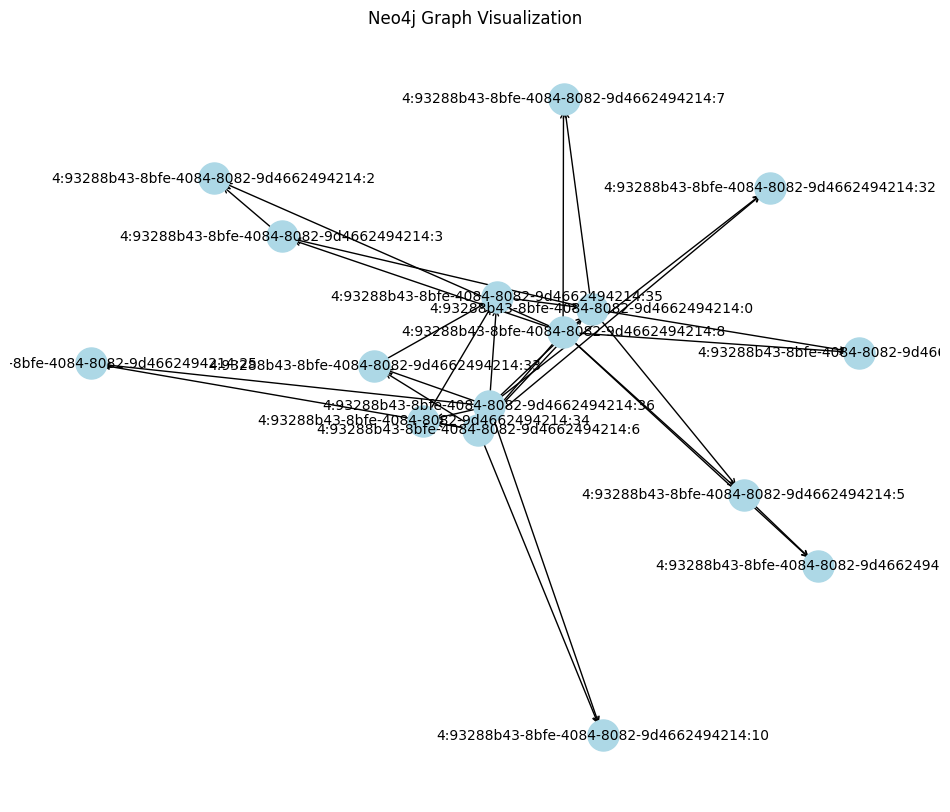

In [69]:
# 使用示例
if __name__ == "__main__":
    # 连接到Neo4j数据库
    uri = "bolt://localhost:7687"
    user = "neo4j"
    password = "neo4j123"  
    
    visualizer = Neo4jVisualizer(uri, user, password)
    
    try:
        # 获取子图数据 - 可以指定node_id和depth
        nodes, relationships = visualizer.get_subgraph(depth=2, limit=100)
        print(nodes)
        # print(relationships)
        # 使用PyVis创建交互式可视化
        visualizer.visualize_with_pyvis(nodes, relationships)
        
        # 可选：使用NetworkX创建静态可视化
        visualizer.visualize_with_networkx(nodes, relationships)
        
    finally:
        visualizer.close()